# Computer Vision Assignment
In this assignment you will be required to create a CV classifier on the [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset. To achieve this you will be required to create and compare different classifier. More precisely you will be asked to:

*   Create the right data-loading pipeline (e.g., Data augmentation, batch size, loading strategy, etc.)
*   Select the proper transfer learning strategy (e.g., fine-tuning, transfer learning, training from scratch) 
*   Select the right hyperparameters (e.g., learning rate, optimizer)

More importantly, you are required to **explain** the choices that you make. To do so, you can also perform different experiments (e.g., comparing two different learning rates or transfer learning strategies) and provide a comment on why one perform better than the other at the end of the notebook. 
You can re-use the notebook that we have been using in the classroom.

You are only provided with:


*   The dataset (directly provided by Torchvision)
*   The neural architecture: a Resnet18 `network = torchvision.models.resnet18()`






In [1]:
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import zipfile
import random
from torch.utils.data import Subset
from pandas import DataFrame
import seaborn as sns
from pandas import DataFrame
import plotly.express as px

cudnn.benchmark = True
plt.ion()   # interactive mode

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device", device)

Device cuda:0


## Loading Data

We will use torchvision and torch.utils.data packages for loading the
data.

The problem we're going to solve today is to train a model to classify ten different objects: *airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck*. We have 50000 training images and 10000 validation images.

We can directly load the dataset from its torchvision class.

> # **Comments:**

*    ``transform``: transforms are used to convert the image data into a tensor, center it and to normalize it (``ToTensor()``, ``Normalize(mean, variance)`` ``CenterCrop(size)``)


*   ``CenterCrop()`` to crop the image at the center and return.


***data augmentation*:**
*   ``RandomResizedCrop(size, [ratio_min, ratio_max])`` which feeds the network with only a part of the original image.

*   ``RandomHorizontalFlip()`` which returnes the the mirrored image with 50% probability. 


In [2]:
train_dir = 'cifar10_train'
val_dir = "cifar10_val"

# Data augmentation and normalization for training
train_transforms = transforms.Compose([
      transforms.RandomResizedCrop(224, [0.75, 1.0]),
      transforms.RandomHorizontalFlip(),
      transforms.ToTensor(),
      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
  ])
# Just normalization for validation
val_transforms = transforms.Compose([
      transforms.Resize(256),
      transforms.CenterCrop(224),
      transforms.ToTensor(),
      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
  ])

train_dataset = torchvision.datasets.CIFAR10(root=train_dir, train=True, 
                                             transform=train_transforms, download=True)
val_dataset = torchvision.datasets.CIFAR10(root=val_dir,train=False, 
                                           transform=val_transforms, download=True)
                                             
train_size = len(train_dataset)
val_size = len(val_dataset)

print("Dataset sizes:", train_size, val_size )

class_names = train_dataset.classes

print("Class names:", class_names)


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting cifar10_train/cifar-10-python.tar.gz to cifar10_train


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting cifar10_val/cifar-10-python.tar.gz to cifar10_val
Dataset sizes: 50000 10000
Class names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Now we have to create the dataloader, as we in the previous lab for the logistic regression. Notice however that we are using one more parameter:

*   ``num_workers`` is used to *parallelize* the loading from disk. 

Indeed, image datasets are too big normally to fit in memory and images are loaded from disk at every batch. In this case we do that using 4 threads to load the 256 images in parallel (4 per thread). 


> # **Comments:**

* ``num_workers`` changed from $4$ to $2$ as there was a warning in the Google Colab.

In [3]:
batch_size = 256
train_dl = torch.utils.data.DataLoader(train_dataset, shuffle=True, 
                                       batch_size=batch_size, num_workers=2)
val_dl = torch.utils.data.DataLoader(val_dataset, 
                                     batch_size=batch_size*2, num_workers=2)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

### Visualize a few images
Let's visualize a few training images so as to understand the data
augmentations.



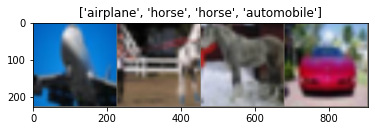

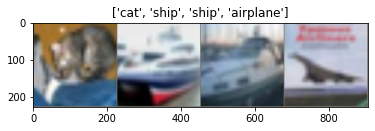

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))  # reconvert to numpy tensor
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean                  # take out normalization
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)                   # pause a bit so that plots are updated


# Get a batch of training data
x, classes = next(iter(train_dl))

# Make a grid from batch
out = torchvision.utils.make_grid(x[:4]) # we only plot the first 4 images
imshow(out, title=[class_names[c] for c in classes[:4]])

# Redo for valid data
x, classes = next(iter(val_dl))
out = torchvision.utils.make_grid(x[:4]) # we only plot the first 4 images
imshow(out, title=[class_names[c] for c in classes[:4]])

> # **Comments:**

* As you can notice in the first row (relating to training data) the images are either zoomed-in (cropped and fitted) or not centered.

* In the second picure of the first row, it is even very diffficult to recognise the horse.

## Select and compare different transfer - learning strategy
You need to compare the 3 learning strategy and comment the results obtained:


*   Transfer Learning (remember to directly extract the features!)
*   Fine tuning 
*   Training from scratch


Start simple! Traning from scratch may be very expensive with this dataset since we have 50000 images. 

Also, to ensure that your code is working, you can use `torch.data.Subset(dataset, indexes)` to use a smaller version of the dataset


> # **Functions:**

* First let us use the functions from the lecture, that can be used in training and comparing the models.


In [4]:
# Function to iterate over data while training
def train_one_epoch(model, train_dl, loss, optim, device):        
    model.train()  # Set model to training mode
    cur_loss, cur_acc = 0.0, 0.0
    for x, y in train_dl:
        x, y = x.to(device), y.to(device)
        
        # zero the parameter gradients
        optim.zero_grad()

        # forward
        outputs = model(x)
        preds = torch.argmax(outputs, 1)
        l = loss(outputs, y)

        # backward + optimize 
        l.backward()
        optim.step()

        # statistics
        cur_loss += l.item() * x.size(0)
        cur_acc += torch.sum(preds == y.data)

    epoch_loss = cur_loss / len(train_dl.dataset)
    epoch_acc = cur_acc.double() / len(train_dl.dataset)
    return epoch_loss, epoch_acc
    
# Function to iterate over data while evaluating
def eval_one_epoch(model, val_dl, loss, device):        
    model.eval()  # Set model to training mode
    cur_loss, cur_acc = 0.0, 0.0
    with torch.no_grad():
        for x, y in val_dl:
            x, y = x.to(device), y.to(device)
            
            # forward
            outputs = model(x)
            preds = torch.argmax(outputs, 1)
            l = loss(outputs, y)

            # statistics
            cur_loss += l.item() * x.size(0)
            cur_acc += torch.sum(preds == y.data)

    epoch_loss = cur_loss / len(val_dl.dataset)
    epoch_acc = cur_acc.double() / len(val_dl.dataset)
    return epoch_loss, epoch_acc

def train_model(model, model_name, train_dl, val_dl, loss, optim, num_epochs=25):
    model.to(device)
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    model_filename = "temp_model_"+model_name+".pt"

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        train_loss, train_acc = train_one_epoch(model, train_dl, loss, optim, device)
        print(f'Train Loss: {train_loss:.4f} Acc: {train_acc:.4f}')

        val_loss, val_acc = eval_one_epoch(model, val_dl, loss, device)
        print(f'Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}\n')

        # save the best model
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), model_filename )

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(torch.load(model_filename))
    return model
  
# Generic function to display model  predictions for a few images

def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (x, y) in enumerate(val_dl):
            x = x.to(device)
            y = y.to(device)

            outputs = model(x)
            _, preds = torch.max(outputs, 1)

            for j in range(x.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(x.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)
        
# To extract features during transfer learning

def extract_features(model, dl, device):
    model.to(device)
    x_extr, y_extr = [], []
    with torch.no_grad():
        for x, y in train_dl:
            x, y = x.to(device), y.to(device)
            preds = cnn_model(x)
            x_extr.append(preds)
            y_extr.append(y)
        x_extr = torch.cat(x_extr, dim=0)
        y_extr = torch.cat(y_extr, dim=0)
        dataset_extr = TensorDataset(x_extr, y_extr)  
    return dataset_extr

> # **1. Transfer Learning:**


In [5]:
loss = nn.CrossEntropyLoss() # Loss function for evaluating the model
num_classes = 10 # No. of classes in our dataset
from torchvision.models import ResNet18_Weights
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import Subset 
from torch.utils.data import TensorDataset

In [ ]:
# EXTRACT FEATURES

cnn_model = models.resnet18(weights=ResNet18_Weights.DEFAULT)
num_ftrs = cnn_model.fc.in_features # To get the size of the feature vector
cnn_model.fc = torch.nn.Identity()

# Extract features for the training dataset
trainset_extr = extract_features(cnn_model, train_dl, device)
train_dl_extr = DataLoader(trainset_extr, batch_size=batch_size, shuffle=True)

# Extract features for the validation dataset
valset_extr = extract_features(cnn_model, val_dl, device)
val_dl_extr = DataLoader(valset_extr, batch_size=batch_size)

# Training the fully connected linear layer using the extracted features
model_fe = nn.Linear(num_ftrs, num_classes)
optimizer_fe = optim.Adam(model_fe.parameters())

model_fe = train_model(model_fe, 'tl', train_dl_extr, val_dl_extr, loss, optimizer_fe, num_epochs=20)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Epoch 0/19
----------
Train Loss: 1.1155 Acc: 0.6495
Val Loss: 0.7996 Acc: 0.7372

Epoch 1/19
----------
Train Loss: 0.7409 Acc: 0.7520
Val Loss: 0.7095 Acc: 0.7586

Epoch 2/19
----------
Train Loss: 0.6859 Acc: 0.7656
Val Loss: 0.6748 Acc: 0.7692

Epoch 3/19
----------
Train Loss: 0.6596 Acc: 0.7724
Val Loss: 0.6578 Acc: 0.7730

Epoch 4/19
----------
Train Loss: 0.6446 Acc: 0.7767
Val Loss: 0.6547 Acc: 0.7732

Epoch 5/19
----------
Train Loss: 0.6344 Acc: 0.7816
Val Loss: 0.6497 Acc: 0.7744

Epoch 6/19
----------
Train Loss: 0.6264 Acc: 0.7820
Val Loss: 0.6415 Acc: 0.7777

Epoch 7/19
----------
Train Loss: 0.6203 Acc: 0.7853
Val Loss: 0.6377 Acc: 0.7790

Epoch 8/19
----------
Train Loss: 0.6129 Acc: 0.7879
Val Loss: 0.6304 Acc: 0.7797

Epoch 9/19
----------
Train Loss: 0.6095 Acc: 0.7893
Val Loss: 0.6297 Acc: 0.7800

Epoch 10/19
----------
Train Loss: 0.6051 Acc: 0.7891
Val Loss: 0.6283 Acc: 0.7806

Epoch 11/19
----------
Train Loss: 0.6048 Acc: 0.7906
Val Loss: 0.6292 Acc: 0.7823

Ep

> # **2. Fine Tuning:**


In [ ]:
model_ft = models.resnet18(weights=ResNet18_Weights)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, num_classes)
model_ft = model_ft.to(device)
optimizer_ft = optim.AdamW(model_ft.parameters(), lr=1e-4)

# Train and evaluate
model_ft = train_model(model_ft, "ft", train_dl, val_dl, loss, optimizer_ft,
                       num_epochs=20)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0/19
----------
Train Loss: 0.4654 Acc: 0.8471
Val Loss: 0.2383 Acc: 0.9232

Epoch 1/19
----------
Train Loss: 0.1738 Acc: 0.9433
Val Loss: 0.1867 Acc: 0.9364

Epoch 2/19
----------
Train Loss: 0.1184 Acc: 0.9611
Val Loss: 0.1791 Acc: 0.9405

Epoch 3/19
----------
Train Loss: 0.0841 Acc: 0.9730
Val Loss: 0.1575 Acc: 0.9470

Epoch 4/19
----------
Train Loss: 0.0639 Acc: 0.9796
Val Loss: 0.1655 Acc: 0.9451

Epoch 5/19
----------
Train Loss: 0.0509 Acc: 0.9839
Val Loss: 0.1658 Acc: 0.9462

Epoch 6/19
----------
Train Loss: 0.0409 Acc: 0.9872
Val Loss: 0.1694 Acc: 0.9468

Epoch 7/19
----------
Train Loss: 0.0350 Acc: 0.9888
Val Loss: 0.1690 Acc: 0.9478

Epoch 8/19
----------
Train Loss: 0.0297 Acc: 0.9913
Val Loss: 0.1595 Acc: 0.9498

Epoch 9/19
----------
Train Loss: 0.0274 Acc: 0.9912
Val Loss: 0.1617 Acc: 0.9485

Epoch 10/19
----------
Train Loss: 0.0281 Acc: 0.9910
Val Loss: 0.1689 Acc: 0.9483

Epoch 11/19
----------
Train Loss: 0.0209 Acc: 0.9937
Val Loss: 0.1657 Acc: 0.9517

Ep

> # **3. Training from scratch:**


In [ ]:
model = models.resnet18(num_classes=num_classes)
model = model.to(device)

# Observe that all parameters are being optimized
optimizer = optim.AdamW(model.parameters(), lr=1e-4)

# Train and evaluate
model = train_model(model, 'scratch', train_dl, val_dl, loss, optimizer, 
                       num_epochs=20)

Epoch 0/19
----------
Train Loss: 1.4356 Acc: 0.4765
Val Loss: 1.3390 Acc: 0.5189

Epoch 1/19
----------
Train Loss: 1.0584 Acc: 0.6203
Val Loss: 1.1623 Acc: 0.5904

Epoch 2/19
----------
Train Loss: 0.8886 Acc: 0.6858
Val Loss: 0.9046 Acc: 0.6802

Epoch 3/19
----------
Train Loss: 0.7765 Acc: 0.7292
Val Loss: 0.7616 Acc: 0.7330

Epoch 4/19
----------
Train Loss: 0.6823 Acc: 0.7630
Val Loss: 0.9050 Acc: 0.6875

Epoch 5/19
----------
Train Loss: 0.6103 Acc: 0.7886
Val Loss: 0.7787 Acc: 0.7343

Epoch 6/19
----------
Train Loss: 0.5540 Acc: 0.8081
Val Loss: 0.6117 Acc: 0.7870

Epoch 7/19
----------
Train Loss: 0.5080 Acc: 0.8256
Val Loss: 0.6604 Acc: 0.7756

Epoch 8/19
----------
Train Loss: 0.4658 Acc: 0.8402
Val Loss: 0.6569 Acc: 0.7778

Epoch 9/19
----------
Train Loss: 0.4381 Acc: 0.8494
Val Loss: 0.6186 Acc: 0.7858

Epoch 10/19
----------
Train Loss: 0.4100 Acc: 0.8573
Val Loss: 0.5537 Acc: 0.8124

Epoch 11/19
----------
Train Loss: 0.3813 Acc: 0.8672
Val Loss: 0.5979 Acc: 0.7989

Ep

> # **Comments:**

**Comparision of 3 learning strategies (for 20 epochs):**

1) Transfer Learning:
    * Best validation accuracy= $78.63$%
    * Training time: 15 sec.

2) Fine Tuning:
    * Best validation accuracy= $95.26$%
    * Training time: 59 min 51 sec.

3) Training from scratch:
    * Best validation accuracy= $83.74$%
    * Training time: 60 min 02 sec.


* **Fine-Tuning strategy is chosen as it has the best accuracy.**
* Transfer Learning takes just 15 sec to train but its accuracy is not comparable to other strategies. This can be due to the fact that we just used the features directly extracted from the ResNet18 model that is pre-trained on another dataset. These features are not found to be very useful for CIFAR-10 dataset. This can be due to the heterogeneity and variability between the two datasets (Although the task is similar). These features cannot accurately approximate the function to make the classification by training just single fully connected layer. This can be overcome by adding more layers to the final fully connected layer or using Fine-Tuning strategy.
* Although Fine-Tuning and Training from scratch takes same time for training, Fine-Tuning performs better since it is initialized with pre-trained weights from ResNet18, which is trained for similar task. This better performance is possible because the weights are already adjusted towards carrying out this specific classification task. In contrast, the weights are randomly initialized in case of "Training from scratch" this results in the network taking more time to update the weights through back propagation and arrive at the optimum weights.
* **Remark:** Both Fine-tuning and Training from scratch results in same performance if they are allowed to train with large number of epochs (say 1000). This is because they are essentially same networks but fine-tuning has an edge because its weights are initialized through transfer learning from a pre-trained model and hence it converges faster than Training from scratch. This is helpful in saving computing resources.

## Select and compare hyperparameters
Once you found the best transfer learning strategy, I want you to find the best hyperparameters: 


*   Learning Rate
*   Data augmentation
*   Optional: optimizer, batch size, etc.




> # Hyperparameters for the Fine-Tuning Strategy

> ## Procedure:

* Since the training takes a lot of time, only a portion of training sample (25% i.e., 12500 images) is used for training (randomly chosen from 50000 images) and performance is validated over 2500 samples (again randomly selected from remaining training sample) to choose the best hyper-parameter.
* This might have effect on overall evaluation metric like accuracy or loss but the relative performance among the hyper-parameters is preserved, as the data considered is still sufficiently large enough.

> ## 1. Learning Rate

In [ ]:
training_size = 12500
validation_size = 2500

random.seed(28)
train_subset = Subset(train_dataset, random.sample(range(int(train_size/4),int(train_size)),training_size))
random.seed(28)
val_subset = Subset(train_dataset, random.sample(range(0,int(train_size/4)),validation_size))


train_dl = torch.utils.data.DataLoader(train_subset, shuffle=True, batch_size=batch_size)
val_h_dl = torch.utils.data.DataLoader(train_subset, shuffle=True, batch_size=batch_size*2)


In [6]:
def compare_model(model, model_name, train_dl, val_dl, loss, optim, num_epochs=25):
    model.to(device)
    since = time.time()

    val_loss_by_epoch = []
    val_acc_by_epoch = []
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        train_loss, train_acc = train_one_epoch(model, train_dl, loss, optim, device)
        print(f'Train Loss: {train_loss:.4f} Acc: {train_acc:.4f}')

        val_loss, val_acc = eval_one_epoch(model, val_dl, loss, device)
        print(f'Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}\n')

        val_loss_by_epoch.append({
            'epoch': epoch,
            'val_loss': val_loss
        })

        val_acc_by_epoch.append({
            'epoch': epoch,
            'val_acc': val_acc
        })


    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

    return {
        'model_name': model_name,
        'val_loss_by_epoch': val_loss_by_epoch,
        'val_acc_by_epoch': val_acc_by_epoch

    }

In [ ]:
model_ft = models.resnet18(weights=ResNet18_Weights)
num_ftrs = model_ft.fc.in_features

lrs = [1e-5,1e-4,0.0005,0.001]
compare_lrs = []
for lr in lrs:
    model_ft.fc = nn.Linear(num_ftrs, num_classes)
    model_ft = model_ft.to(device)
    optimizer_ft = optim.AdamW(model_ft.parameters(), lr=lr)

    comparison = compare_model(model_ft, lr, train_dl, val_h_dl, loss, optimizer_ft, num_epochs=20)
    compare_lrs.append(comparison)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Epoch 0/19
----------
Train Loss: 2.0532 Acc: 0.2918
Val Loss: 1.6271 Acc: 0.4790

Epoch 1/19
----------
Train Loss: 1.3528 Acc: 0.6118
Val Loss: 1.0992 Acc: 0.6929

Epoch 2/19
----------
Train Loss: 0.9814 Acc: 0.7292
Val Loss: 0.8364 Acc: 0.7611

Epoch 3/19
----------
Train Loss: 0.7791 Acc: 0.7780
Val Loss: 0.6839 Acc: 0.8046

Epoch 4/19
----------
Train Loss: 0.6557 Acc: 0.8076
Val Loss: 0.5911 Acc: 0.8294

Epoch 5/19
----------
Train Loss: 0.5669 Acc: 0.8346
Val Loss: 0.5128 Acc: 0.8522

Epoch 6/19
----------
Train Loss: 0.4953 Acc: 0.8526
Val Loss: 0.4541 Acc: 0.8689

Epoch 7/19
----------
Train Loss: 0.4430 Acc: 0.8712
Val Loss: 0.4058 Acc: 0.8818

Epoch 8/19
----------
Train Loss: 0.3993 Acc: 0.8857
Val Loss: 0.3667 Acc: 0.8955

Epoch 9/19
----------
Train Loss: 0.3613 Acc: 0.8959
Val Loss: 0.3368 Acc: 0.9033

Epoch 10/19
----------
Train Loss: 0.3376 Acc: 0.8998
Val Loss: 0.3079 Acc: 0.9119

Epoch 11/19
----------
Train Loss: 0.3087 Acc: 0.9080
Val Loss: 0.2855 Acc: 0.9194

Ep

In [ ]:
for lr_comparison in compare_lrs:
  df_compare_lr = DataFrame(lr_comparison['val_acc_by_epoch'])
  plt.plot(df_compare_lr['epoch'], df_compare_lr['val_acc'], label='lr = '+str(lr_comparison['model_name']))

plt.ylabel('Validation accuracy')
plt.xlabel('# epoch')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

> ## Learning Rate Analysis:



In [7]:
lr = 0.0001

> ## 2. Data Augmentation Technique

In [8]:
def get_train_val_dls(train_dir, compose_list, training_size, validation_size, batch_size=256):

    # Data augmentation and normalization for training
    train_transforms = transforms.Compose(compose_list)

    train_dataset_transforms = torchvision.datasets.CIFAR10(root=train_dir, train=True, transform=train_transforms, download=True)
    train_dataset_no_transforms = torchvision.datasets.CIFAR10(root=train_dir, train=True, transform=val_transforms, download=True)

    random.seed(28)
    train_dataset = Subset(train_dataset_transforms, random.sample(range(int(train_size/4),int(train_size)),training_size))
    random.seed(28)
    val_dataset = Subset(train_dataset_no_transforms, random.sample(range(0,int(train_size/4)),validation_size))

    train_dl = torch.utils.data.DataLoader(train_dataset, shuffle=True,batch_size=batch_size, num_workers=2)
    val_dl = torch.utils.data.DataLoader(val_dataset, shuffle=True,batch_size=batch_size*2, num_workers=2)
    
    return train_dl, val_dl

def compare_model_data_aug(model_name, data_transform, num_classes, lr, num_epochs, training_size, validation_size):

    train_dl, val_dl = get_train_val_dls('cifar10_train_'+model_name, data_transform, training_size, validation_size)

    model_ft = models.resnet18(weights=ResNet18_Weights)

    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs, num_classes)

    model_ft = model_ft.to(device)
    optimizer_ft = optim.AdamW(model_ft.parameters(), lr=lr)

    return compare_model(model_ft, model_name, train_dl, val_dl, loss, optimizer_ft, num_epochs=num_epochs)

In [9]:
without_data_aug = [
      transforms.Resize(256),
      transforms.CenterCrop(224),
      transforms.ToTensor(),
      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]
with_data_aug =  [
    transforms.RandomResizedCrop(224, [0.75, 1.0]),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]

In [ ]:
num_epochs = 20

compare_aug = []

compare_aug.append(
    compare_model_data_aug('without_data_aug', without_data_aug, num_classes, lr, num_epochs, training_size=12500, validation_size=2500)
)


compare_aug.append(
    compare_model_data_aug('with_data_aug', with_data_aug, num_classes, lr, num_epochs, training_size=12500, validation_size=2500)
)

Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0/14
----------
Train Loss: 2.0051 Acc: 0.3070
Val Loss: 2.3625 Acc: 0.0930

Epoch 1/14
----------
Train Loss: 1.1667 Acc: 0.6196
Val Loss: 2.6754 Acc: 0.0940

Epoch 2/14
----------
Train Loss: 0.7385 Acc: 0.7810
Val Loss: 2.9808 Acc: 0.0960

Epoch 3/14
----------
Train Loss: 0.4582 Acc: 0.8894
Val Loss: 3.0983 Acc: 0.0940

Epoch 4/14
----------
Train Loss: 0.2778 Acc: 0.9452
Val Loss: 3.0814 Acc: 0.0940

Epoch 5/14
----------
Train Loss: 0.1599 Acc: 0.9758
Val Loss: 3.1157 Acc: 0.0910

Epoch 6/14
----------
Train Loss: 0.0922 Acc: 0.9932
Val Loss: 3.0149 Acc: 0.0910

Epoch 7/14
----------
Train Loss: 0.0554 Acc: 0.9986
Val Loss: 3.0515 Acc: 0.0910

Epoch 8/14
----------
Train Loss: 0.0354 Acc: 0.9988
Val Loss: 3.0152 Acc: 0.0950

Epoch 9/14
----------
Train Loss: 0.0249 Acc: 0.9996
Val Loss: 3.0647 Acc: 0.0880

Epoch 10/14
----------
Train Loss: 0.0191 Acc: 1.0000
Val Loss: 3.1058 Acc: 0.0870

Epoch 11/14
----------
Train Loss: 0.0150 Acc: 1.0000
Val Loss: 3.1659 Acc: 0.0880

Ep

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting cifar10_train_flip/cifar-10-python.tar.gz to cifar10_train_flip
Files already downloaded and verified
Epoch 0/14
----------
Train Loss: 2.0991 Acc: 0.2754
Val Loss: 2.3684 Acc: 0.1000

Epoch 1/14
----------
Train Loss: 1.3361 Acc: 0.5610
Val Loss: 2.6838 Acc: 0.1110

Epoch 2/14
----------
Train Loss: 0.9629 Acc: 0.6920
Val Loss: 3.1124 Acc: 0.1160

Epoch 3/14
----------
Train Loss: 0.7034 Acc: 0.7836
Val Loss: 3.2149 Acc: 0.1120

Epoch 4/14
----------
Train Loss: 0.5321 Acc: 0.8402
Val Loss: 3.4700 Acc: 0.1100

Epoch 5/14
----------
Train Loss: 0.3969 Acc: 0.8920
Val Loss: 3.5371 Acc: 0.1110

Epoch 6/14
----------
Train Loss: 0.2873 Acc: 0.9300
Val Loss: 3.5922 Acc: 0.1090

Epoch 7/14
----------
Train Loss: 0.2011 Acc: 0.9554
Val Loss: 3.4603 Acc: 0.1130

Epoch 8/14
----------
Train Loss: 0.1460 Acc: 0.9730
Val Loss: 3.7294 Acc: 0.1170

Epoch 9/14
----------
Train Loss: 0.1071 Acc: 0.9830
Val Loss: 3.6005 Acc: 0.1110

Epoch 10/14
----------
Train Loss: 0.0776 Acc: 0.9904
Val

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting cifar10_train_resize_and_flip/cifar-10-python.tar.gz to cifar10_train_resize_and_flip
Files already downloaded and verified
Epoch 0/14
----------
Train Loss: 1.3948 Acc: 0.5500
Val Loss: 0.7337 Acc: 0.7500

Epoch 1/14
----------
Train Loss: 0.5811 Acc: 0.8238
Val Loss: 0.5030 Acc: 0.8290

Epoch 2/14
----------
Train Loss: 0.3522 Acc: 0.8978
Val Loss: 0.4255 Acc: 0.8570

Epoch 3/14
----------
Train Loss: 0.2471 Acc: 0.9304
Val Loss: 0.3727 Acc: 0.8780

Epoch 4/14
----------
Train Loss: 0.1801 Acc: 0.9500
Val Loss: 0.3431 Acc: 0.8810

Epoch 5/14
----------
Train Loss: 0.1259 Acc: 0.9704
Val Loss: 0.3199 Acc: 0.8900

Epoch 6/14
----------
Train Loss: 0.0965 Acc: 0.9808
Val Loss: 0.3318 Acc: 0.8820

Epoch 7/14
----------
Train Loss: 0.0639 Acc: 0.9892
Val Loss: 0.3017 Acc: 0.9010

Epoch 8/14
----------
Train Loss: 0.0519 Acc: 0.9918
Val Loss: 0.2965 Acc: 0.9070

Epoch 9/14
----------
Train Loss: 0.0428 Acc: 0.9932
Val Loss: 0.3114 Acc: 0.8920

Epoch 10/14
----------
Train Loss: 

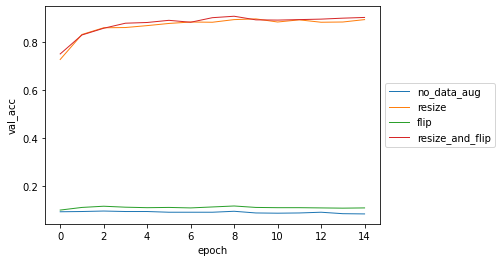

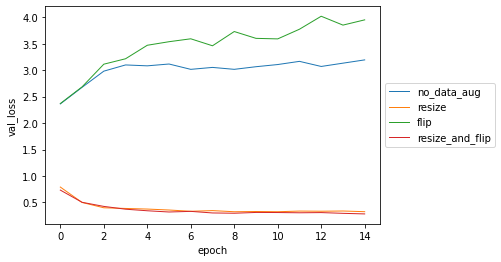

In [ ]:
for aug_comparison in compare_aug:
  df_compare_aug = DataFrame(aug_comparison['val_acc_by_epoch'])
  plt.plot(df_compare_aug['epoch'], df_compare_aug['val_acc'], label=aug_comparison['model_name'], linewidth=1)

plt.ylabel('Validation Accuracy')
plt.xlabel('# Epochs')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


for aug_comparison in compare_aug:
  df_compare_aug = DataFrame(aug_comparison['val_loss_by_epoch'])
  plt.plot(df_compare_aug['epoch'], df_compare_aug['val_loss'], label=aug_comparison['model_name'], linewidth=1)

plt.ylabel('Validation Loss')
plt.xlabel('# Epochs')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

> ## 3. Optimizer

In [ ]:
train_dl, val_dl = get_train_val_dls('with_data_aug', with_data_aug, training_size=12500, validation_size=2500)
optim_dict = {
'AdamW': optim.AdamW,
'SGD': optim.SGD,
'Adam': optim.Adam,
'AdaGrad': optim.Adagrad
}

compare_optim = []
for name, optimizer in optim_dict.items():

    model_ft = models.resnet18(weights=ResNet18_Weights)

    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs, num_classes)

    model_ft = model_ft.to(device)
    optimizer_ft = optimizer(model_ft.parameters(), lr=lr)

    comparison = compare_model(
        model_ft, name, train_dl, val_dl, loss, optimizer_ft, num_epochs=20
    )
    compare_optim.append(comparison)

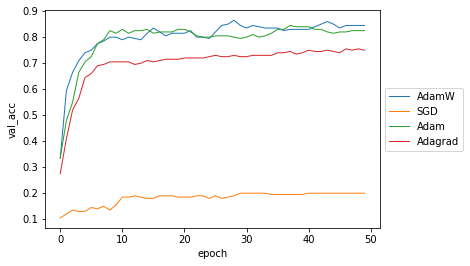

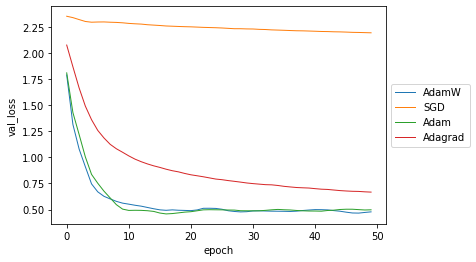

In [ ]:
df_compare_optim = DataFrame(compare_optim)
df_compare_optim

for optim_comparison in compare_optim:
  df_compare_optim = DataFrame(optim_comparison['val_acc_by_epoch'])
  plt.plot(df_compare_optim['epoch'], df_compare_optim['val_acc'], label=optim_comparison['model_name'], linewidth=1)

plt.ylabel('Validation Accuracy')
plt.xlabel('# Epochs')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


for optim_comparison in compare_optim:
  df_compare_optim = DataFrame(optim_comparison['val_loss_by_epoch'])
  plt.plot(df_compare_optim['epoch'], df_compare_optim['val_loss'], label=optim_comparison['model_name'], linewidth=1)

plt.ylabel('Validation Loss')
plt.xlabel('# Epochs')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


I have chosen NLLL loss because

In [10]:
loss = nn.NLLLoss()

> ## 4. Batch size

In [13]:
batch_sizes = [64, 128, 256, 512]

compare_batch_sizes = []
for batch_size in batch_sizes:
    train_dl, val_dl = get_train_val_dls('with_data_aug', with_data_aug, training_size=7000, validation_size=1400, batch_size=batch_size)
    model_ft = models.resnet18(weights=ResNet18_Weights)

    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Sequential(
        nn.Linear(num_ftrs, num_classes),
        nn.Softmax(),
    )  # Softmax layer for Negative Log Likelihood for regularization.

    model_ft = model_ft.to(device)
    optimizer_ft = optim.AdamW(model_ft.parameters(), lr=lr)


    comparison = compare_model(
        model_ft, batch_size, train_dl, val_dl, loss, optimizer_ft, num_epochs=25
    )
    compare_batch_sizes.append(comparison)


Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0/24
----------


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Train Loss: -0.5813 Acc: 0.6441
Val Loss: -0.7870 Acc: 0.8186

Epoch 1/24
----------
Train Loss: -0.8368 Acc: 0.8711
Val Loss: -0.8397 Acc: 0.8614

Epoch 2/24
----------
Train Loss: -0.8836 Acc: 0.9070
Val Loss: -0.8628 Acc: 0.8871

Epoch 3/24
----------
Train Loss: -0.9147 Acc: 0.9347
Val Loss: -0.8654 Acc: 0.8814

Epoch 4/24
----------
Train Loss: -0.9362 Acc: 0.9521
Val Loss: -0.8735 Acc: 0.8900

Epoch 5/24
----------
Train Loss: -0.9428 Acc: 0.9571
Val Loss: -0.8752 Acc: 0.8950

Epoch 6/24
----------
Train Loss: -0.9512 Acc: 0.9621
Val Loss: -0.8816 Acc: 0.8943

Epoch 7/24
----------
Train Loss: -0.9619 Acc: 0.9717
Val Loss: -0.8899 Acc: 0.9071

Epoch 8/24
----------
Train Loss: -0.9688 Acc: 0.9784
Val Loss: -0.8817 Acc: 0.8900

Epoch 9/24
----------
Train Loss: -0.9701 Acc: 0.9784
Val Loss: -0.8896 Acc: 0.9021

Epoch 10/24
----------
Train Loss: -0.9743 Acc: 0.9826
Val Loss: -0.8950 Acc: 0.9036

Epoch 11/24
----------
Train Loss: -0.9753 Acc: 0.9816
Val Loss: -0.8895 Acc: 0.8979



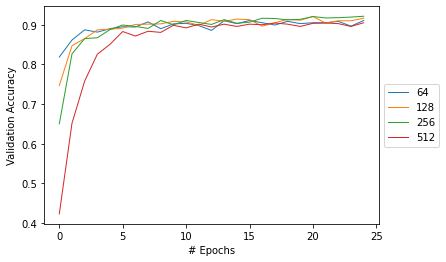

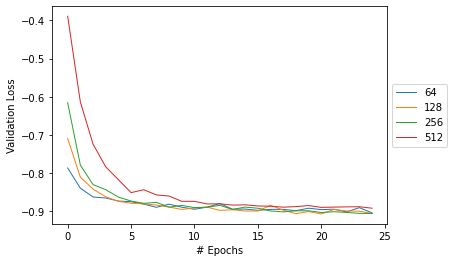

In [14]:
for bs_comparison in compare_batch_sizes:
  df_compare_bs = DataFrame(bs_comparison['val_acc_by_epoch'])
  plt.plot(df_compare_bs['epoch'], df_compare_bs['val_acc'], label=bs_comparison['model_name'], linewidth=1)

plt.ylabel('Validation Accuracy')
plt.xlabel('# Epochs')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


for bs_comparison in compare_batch_sizes:
  df_compare_bs = DataFrame(bs_comparison['val_loss_by_epoch'])
  plt.plot(df_compare_bs['epoch'], df_compare_bs['val_loss'], label=bs_comparison['model_name'], linewidth=1)

plt.ylabel('Validation Loss')
plt.xlabel('# Epochs')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

> # Final Model after selecting hyper-parameters

In [ ]:
train_dir = 'cifar10_train'
val_dir = "cifar10_val"

train_transforms = transforms.Compose([
      transforms.RandomResizedCrop(224, [0.75, 1.0]),
      transforms.RandomHorizontalFlip(),
      transforms.ToTensor(),
      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
  ])

val_transforms = transforms.Compose([
      transforms.Resize(256),
      transforms.CenterCrop(224),
      transforms.ToTensor(),
      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
  ])
train_dataset = torchvision.datasets.CIFAR10(root=train_dir, train=True, 
                                             transform=train_transforms, download=True)
val_dataset = torchvision.datasets.CIFAR10(root=val_dir,train=False, 
                                           transform=val_transforms, download=True)
train_size = len(train_dataset)
val_size = len(val_dataset)

batch_size_final = 256

train_dl = torch.utils.data.DataLoader(train_dataset, shuffle=True, 
                                       batch_size=batch_size, num_workers=2)
val_dl = torch.utils.data.DataLoader(val_dataset, 
                                     batch_size=batch_size*2, num_workers=2)
model_ft_final = models.resnet18(weights=ResNet18_Weights)
num_ftrs = model_ft_final.fc.in_features
model_ft_final.fc = nn.Sequential(
    nn.Linear(num_ftrs, num_classes),
    nn.Softmax(),
) # Softmax layer for Negative Log Likelihood for regularization.
model_ft_final = model_ft_final.to(device)
optimizer_ft_final = optim.AdamW(model_ft_final.parameters(), lr=0.0001)

# Train and evaluate
model_ft_final = train_model(model_ft_final, "ft_final", train_dl, val_dl, loss= nn.NLLLoss(), optimizer_ft= optimizer_ft_final, num_epochs=20)

## Evaluation of the assignment
The evaluation of the assignment will be based on 3 different aspects:

*   Percentage of assignment completed (50 % of the grade)
*   Correctness of the comments used to explain the result (40% of the grade)
*   Validation accuracy of the final model provided (10 % of the grade)

